# Playing around with DFEs

The distribution of fitness effects (DFE) of new mutations describes the probability that a new mutation (of a given class, e.g. synonymous, missense, loss-of-function, non-coding regulatory elements) has a given selection coefficient. Note that different classes of mutations, or different partitions of protein-coding genes, can have different DFEs, so it's important to specify what class of mutations we are referring to.

In this notebook, we'll use some of the results from [Kim et al. (2017)](https://academic.oup.com/genetics/article/206/1/345/6064197) as well as results from the [`moments` documentation](https://moments.readthedocs.io/en/latest/modules/dfe.html) which walks through DFE inference using the site frequency spectrum (SFS).

Both the Kim et al. paper and the `moments` documentation would be good to read through in addition to this notebook. This notebook was created with `moments` version 1.1.3 installed, but probably any version would work.

In [1]:
# import some packages we'll need
import moments
print("moments version:", moments.__version__)
import numpy as np
import scipy.stats
import matplotlib.pylab as plt
import copy

moments version: 1.1.3


The true DFE for a set of mutations will not perfectly follow some known mathematical functional form. Instead, when inferring the DFE from the data, we *assume* some plausible distribution that hopefully reasonably approximates the underlying true distribution while also needing only a few parameters to describe that distribution. Commonly used distributions include [gamma](https://en.wikipedia.org/wiki/Gamma_distribution), [lognormal](https://en.wikipedia.org/wiki/Log-normal_distribution), and discrete distributions (where probabilities are given for a small discrete set of possible *s* values). For some reason, gamma distributions are very popular in the DFE literature, so we'll also just look at gamma distributions. But note that this choice is mostly for convenience and consistency with previous studies.

For example, the gamma-DFE inferred in Kim et al. (using Thousand Genomes European populations) had $\alpha=0.186$ and $\beta= 875.0$. This assumes all mutations have selection coefficients $s\in[-\infty, 0)$, i.e. only allows neutral or deleterious mutations for nonsynonymous variants. We can plot what this distribution looks like (see [scipy.stats.gamma](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gamma.html) documentation for how to define the distribution in Python):

Binned probabilities of new mutation selection coefficients (-s)
Prob(new |s|<1e-5) = 0.228
Prob(new 1e-5<=|s|<1e-4) = 0.122
Prob(new 1e-4<=|s|<1e-3) = 0.185
Prob(new 1e-3<=|s|<1e-2) = 0.261
Prob(new |s|>1e-2) = 0.204
Binned probabilities of new mutation selection coefficients (-s)
Prob(new |s|<1e-5) = 0.228
Prob(new 1e-5<=|s|<1e-4) = 0.122
Prob(new 1e-4<=|s|<1e-3) = 0.185
Prob(new 1e-3<=|s|<1e-2) = 0.261
Prob(new |s|>1e-2) = 0.204


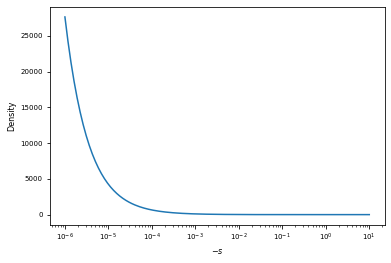

In [2]:
kim_params = (0.186, 875.0) # note that this describes the distribution of |2*Ne*s|, so we must convert using Ne

Ne = 10000 # rough estimate of Ne - might have been more exact in the paper

#### using the 2Ns distribution

print("Binned probabilities of new mutation selection coefficients (-s)")
print(f"Prob(new |s|<1e-5) = {scipy.stats.gamma.cdf(2 * Ne * 1e-5, kim_params[0], scale=kim_params[1]):.3f}")
print(f"Prob(new 1e-5<=|s|<1e-4) = {scipy.stats.gamma.cdf(2 * Ne * 1e-4, kim_params[0], scale=kim_params[1]) - scipy.stats.gamma.cdf(2 * Ne * 1e-5, kim_params[0], scale=kim_params[1]):.3f}")
print(f"Prob(new 1e-4<=|s|<1e-3) = {scipy.stats.gamma.cdf(2 * Ne * 1e-3, kim_params[0], scale=kim_params[1]) - scipy.stats.gamma.cdf(2 * Ne * 1e-4, kim_params[0], scale=kim_params[1]):.3f}")
print(f"Prob(new 1e-3<=|s|<1e-2) = {scipy.stats.gamma.cdf(2 * Ne * 1e-2, kim_params[0], scale=kim_params[1]) - scipy.stats.gamma.cdf(2 * Ne * 1e-3, kim_params[0], scale=kim_params[1]):.3f}")
print(f"Prob(new |s|>1e-2) = {1 - scipy.stats.gamma.cdf(2 * Ne * 1e-2, kim_params[0], scale=kim_params[1]):.3f}")

#### rescaling the distribution, the shape is divided by 2Ne so that we get the distribution on s instead of 2Nes
kim_params_rescaled = (0.186, 875.0 / 2 / Ne)
print("Binned probabilities of new mutation selection coefficients (-s)")
print(f"Prob(new |s|<1e-5) = {scipy.stats.gamma.cdf(1e-5, kim_params_rescaled[0], scale=kim_params_rescaled[1]):.3f}")
print(f"Prob(new 1e-5<=|s|<1e-4) = {scipy.stats.gamma.cdf(1e-4, kim_params_rescaled[0], scale=kim_params_rescaled[1]) - scipy.stats.gamma.cdf(1e-5, kim_params_rescaled[0], scale=kim_params_rescaled[1]):.3f}")
print(f"Prob(new 1e-4<=|s|<1e-3) = {scipy.stats.gamma.cdf(1e-3, kim_params_rescaled[0], scale=kim_params_rescaled[1]) - scipy.stats.gamma.cdf(1e-4, kim_params_rescaled[0], scale=kim_params_rescaled[1]):.3f}")
print(f"Prob(new 1e-3<=|s|<1e-2) = {scipy.stats.gamma.cdf(1e-2, kim_params_rescaled[0], scale=kim_params_rescaled[1]) - scipy.stats.gamma.cdf(1e-3, kim_params_rescaled[0], scale=kim_params_rescaled[1]):.3f}")
print(f"Prob(new |s|>1e-2) = {1 - scipy.stats.gamma.cdf(1e-2, kim_params_rescaled[0], scale=kim_params_rescaled[1]):.3f}")


#### plot distribution of s

x = np.logspace(-6, 1, 201)
kim_dfe = scipy.stats.gamma.pdf(x, kim_params_rescaled[0], scale=kim_params_rescaled[1])

plt.plot(x, kim_dfe);
plt.xscale("log");
plt.xlabel("$-s$");
plt.ylabel("Density");

## Getting the expected SFS from the DFE

So we've talked about what the DFE is -- what does it actually mean for observed allele frequencies and diversity in a sample? If we know the demographic history and mutation rate, we can compute the expected SFS. First, we can use `moments` to compute the expected SFS for a *given* selection coefficient.

First, let's just assume a constant size history, and we'll just set the scaled mutation rate $\theta = 4N_e\mu = 1$. We can plot the SFS for different selection coeffients:

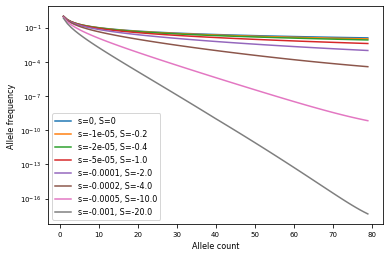

In [3]:
n = 80 # number of sampled chromosomes

for s in [0, -1e-5, -2e-5, -5e-5, -1e-4, -2e-4, -5e-4, -1e-3]:
    S = 2 * Ne * s
    fs = moments.Spectrum(moments.LinearSystem_1D.steady_state_1D(n, gamma=S))
    plt.plot(fs, label=f"s={s}, S={S}")

plt.yscale("log")
plt.xlabel("Allele count")
plt.ylabel("Allele frequency")
plt.legend()
# note that we plot on log-y scale

What do we notice? For selection weaker than s=-5e-5, which corresponds to scaled selection coefficient 2Ns of -1, the SFS behaves more or less neutrally. This is a weak selection regime. For 2Ns of -1 and larger, selection is stronger and mutations are held at lower frequency so that we shouldn't see many strongly deleterious mutations in many of the sampled chromosomes. Those mutations are lost relatively rapidly compared to neutral mutations.

Our goal is to combine what we plotted above with the DFE to get the SFS for classes of mutations that can have differing selection coefficients. To do this, we use an approach similar to equation (1) in Kim et al, and integrate over frequency spectra weighted by the underlying DFE. The $i$th bin of the SFS will then be given by $$F_{DFE}[i] = \int_{-\infty}^0 F_{s}[i] \times \Gamma(s;\alpha, \beta) ds,$$ where $F_s$ is the frequency spectrum for the given selection coefficient.

Since we are computing the SFS numerically using `moments`, we can't compute this integral in this way. Instead, we discretize the DFE and compute this integral numerically (there should be more information about this in the moments docs or in the Kim et al paper).

We discretize the $x$-axis. Here, I'll use 50 bins, ranging from 2Ns=-0.01 to 2Ns = -100. This sacrifices some accuracy for computational efficiency. To be more accurate, we'd use more bins and a larger range of 2Ns values. We assume that all mutations that have 2Ns smaller than -0.01 are effectively neutral, so we can approximate any mutation with $|s| < 0.01 / 2N$ as having $s=0$. Similarly, for 2Ns more severe than -100, we assume that those mutations are so deleterious that we can approximate them as lethal, and just assume that those mutations are not seen at any frequency in the sample. For the bins in between, I like to discretize on a log scale.

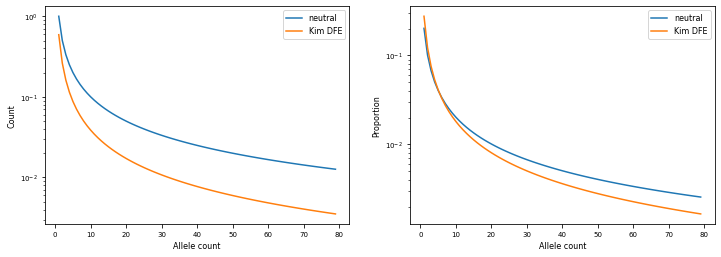

In [4]:
# the discretized points to compute the weights at
S = np.logspace(-2, 2, 51)
# non-uniform discritization (log), so need to get widths for numerical integration
dSs = ((S - np.concatenate(([S[0]], S))[:-1]) / 2 + (np.concatenate((S, [S[-1]]))[1:] - S) / 2)

fs_neutral = moments.Spectrum(moments.LinearSystem_1D.steady_state_1D(80, gamma=0))

def dfe_func(params, ns, theta=1):
    """
    params = (alpha, beta)
    ns = sample size
    theta = 4Nu, scaled mutation rate
    """
    alpha, beta = params
    # start with effectively neutral mutations
    fs = fs_neutral * scipy.stats.gamma.cdf(S[0], alpha, scale=beta)
    weights = scipy.stats.gamma.pdf(S, alpha, scale=beta)
    # then add each discretized selected mutations
    for S_val, dS, w in zip(S, dSs, weights):
        temp_fs = moments.Spectrum(moments.LinearSystem_1D.steady_state_1D(ns, gamma=-S_val))
        fs += temp_fs * dS * w
    # finally, scale by mutation rate
    fs = theta * fs
    return fs

fs_kim = dfe_func(kim_params, 80)


fig = plt.figure(figsize=(12, 4))
ax1 = plt.subplot(1, 2, 1)
ax1.plot(fs_neutral, label="neutral")
ax1.plot(fs_kim, label="Kim DFE")
ax1.set_yscale("log")
ax1.set_ylabel("Count")
ax1.set_xlabel("Allele count")
ax1.legend()
ax2 = plt.subplot(1, 2, 2)
ax2.plot(fs_neutral / fs_neutral.S(), label="neutral")
ax2.plot(fs_kim / fs_kim.S(), label="Kim DFE")
ax2.set_yscale("log")
ax2.set_ylabel("Proportion")
ax2.set_xlabel("Allele count")
ax2.legend()

Notice that the both the total number of expected segregating mutations under the DFE is less than under neutrality (as expected, since many mutations are deleterious and purged from the population). Also, they are skewed to more rare alele frequencies, as can be seen on the right when comparing the frequency spectra by proportion. The extent of the reduction of diversity and the skew to rare frequencies will depend on the underlying DFE: A DFE with more weight toward strongly deleterious mutations would presumably make both of those observations even stronger.

### How does non-steady-state demographic history change this picture?

We can create the same plot as above, but under the assumption that the sampled population went through some size changes including bottlenecks and expansions. The Kim DFE used above was inferred from the Thousand Genomes European populations. 

**Go back and get the inferred demographic history from Kim et al**

In [5]:
def kim_demog(Ne=10000, s=0, n=80):
    S = 2 * Ne * s
    fs = moments.Spectrum(moments.LinearSystem_1D.steady_state_1D(n, gamma=S))
    # bottleneck
    fs.integrate([0.1], 0.2, gamma=S)
    # recovery
    fs.integrate([2.0], 0.1, gamma=S)
    # recent expansion
    fs.integrate([10.0], 0.05, gamma=S)
    return fs

selection coefficient 0 needed sample size of 80
selection coefficient -1e-05 needed sample size of 80
selection coefficient -2e-05 needed sample size of 80
selection coefficient -5e-05 needed sample size of 80
selection coefficient -0.0001 needed sample size of 80
selection coefficient -0.0002 needed sample size of 80
selection coefficient -0.0005 needed sample size of 80
selection coefficient -0.001 needed sample size of 320
selection coefficient -0.002 needed sample size of 640
selection coefficient -0.005 needed sample size of 1280
selection coefficient -0.01 needed sample size of 2560
selection coefficient -0.02 needed sample size of 5120
selection coefficient -0.05 needed sample size of 20480


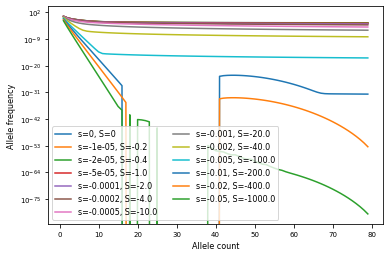

In [6]:
Ne = 10000
for s in [0, -1e-5, -2e-5, -5e-5, -1e-4, -2e-4, -5e-4, -1e-3, -2e-3, -5e-3, -1e-2, -2e-2, -5e-2]:
    temp_n = copy.copy(n)
    temp_fs = kim_demog(Ne=Ne, s=s, n=temp_n)
    while np.any(temp_fs < -1e-8) or np.isnan(temp_fs[1]):
        # this loop controls the error - when there is numerical error,
        # we can increase the sample size and later project
        #print("\t", temp_n, np.min(temp_fs))
        temp_n *= 2
        temp_fs = kim_demog(Ne=Ne, s=s, n=temp_n)
    fs = temp_fs.project([80])
    print(f"selection coefficient {s} needed sample size of {temp_n}")
    plt.plot(fs, label=f"s={s}, S={2 * 10000 * s}")

plt.yscale("log")
plt.xlabel("Allele count")
plt.ylabel("Allele frequency")
plt.legend(ncol=2)
# note that we plot on log-y scale

Note that there is some numerical error for the very strong selection coefficients (which is why I caught when the computed SFS had large error and recomputed with a larger sample size). The errors look large, but note that we're on log scale and those entries are practically zero. That makes sense though - very strongly deleterious mutations should not be found at high frequencies.

Compare to the plot for different *s* values above - we see the same pattern than at around 2Ns of 1, deleterious mutations start behaving non-neutrally. But the shape of the SFS are quite different due to the population size reduction and subsequent expansions in its history.

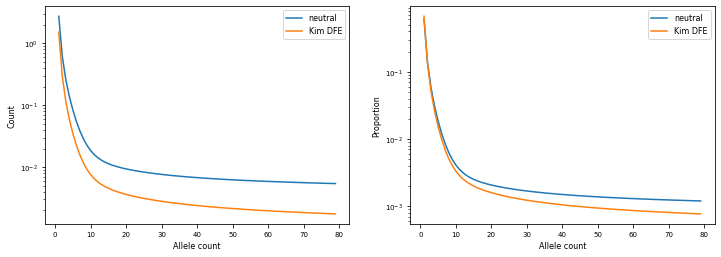

In [7]:
def dfe_func_demog(params, n, theta=1, Ne=10000):
    """
    params = (alpha, beta)
    n = sample size
    theta = 4Nu, scaled mutation rate
    """
    alpha, beta = params
    # start with effectively neutral mutations
    fs = kim_demog(Ne=Ne, s=0, n=n)
    fs *= scipy.stats.gamma.cdf(S[0], alpha, scale=beta)
    weights = scipy.stats.gamma.pdf(S, alpha, scale=beta)
    # then add each discretized selected mutations
    for S_val, dS, w in zip(S, dSs, weights):
        s = -S_val / 2 / Ne
        #print(s)
        temp_n = copy.copy(n)
        temp_fs = kim_demog(Ne=Ne, s=s, n=temp_n)
        while np.any(temp_fs < -1e-8) or np.isnan(temp_fs[1]):
            #print("\t", temp_n, np.min(temp_fs))
            temp_n *= 2
            temp_fs = kim_demog(Ne=Ne, s=s, n=temp_n)
        temp_fs = temp_fs.project([80])
        #print("\t", temp_n, np.min(temp_fs))
        fs += temp_fs * dS * w
    # finally, scale by mutation rate
    fs = theta * fs
    return fs

fs_neutral_demog = kim_demog(Ne=Ne, s=0, n=80)
fs_kim_demog = dfe_func_demog(kim_params, 80)

fig = plt.figure(figsize=(12, 4))
ax1 = plt.subplot(1, 2, 1)
ax1.plot(fs_neutral_demog, label="neutral")
ax1.plot(fs_kim_demog, label="Kim DFE")
ax1.set_yscale("log")
ax1.set_ylabel("Count")
ax1.set_xlabel("Allele count")
ax1.legend()
ax2 = plt.subplot(1, 2, 2)
ax2.plot(fs_neutral_demog / fs_neutral_demog.S(), label="neutral")
ax2.plot(fs_kim_demog / fs_kim_demog.S(), label="Kim DFE")
ax2.set_yscale("log")
ax2.set_ylabel("Proportion")
ax2.set_xlabel("Allele count")
ax2.legend()

## What is the distribution of observed selection coefficients and each allele frequency?



## Comparing missense and loss-of-function mutations

